In [ ]:
!pip install split-folders
!pip install vit-pytorch
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.4
    Uninstalling gdown-4.6.4:
      Successfully uninstalled gdown-4.6.4


In [ ]:
from __future__ import print_function

import glob
from itertools import chain
import os
from os import listdir
from os.path import join
import random
import zipfile
import logging
import time
import copy
import gdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import (RandomRotation, RandomCrop,
                                    Pad, Resize, RandomAffine,
                                    ToTensor, Compose, RandomPerspective)
from tqdm.notebook import tqdm
import splitfolders
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [ ]:
os.makedirs('data', exist_ok=True)
os.makedirs("model", exist_ok=True)

In [ ]:
if not os.path.isfile('data/lenses.tgz'):
    url = "https://drive.google.com/uc?id=16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr"
    output = "data/lenses.tgz"
    gdown.download(url, output, quiet=False)
else:
    print("File exists")

Downloading...
From: https://drive.google.com/uc?id=16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr
To: /content/data/lenses.tgz
100%|██████████| 5.46M/5.46M [00:00<00:00, 57.6MB/s]


In [ ]:
data_dir = 'data/lenses'

if os.path.isdir(data_dir):
    print("Extracted folder exists")
else:
    print("Extracting folder")
    os.system('tar xf data/lenses.tgz --directory data ; mv data/lenses data/lenses_raw')
    splitfolders.ratio('data/lenses_raw', output="data/lenses", seed=1337, ratio=(.9, 0.1))
    os.system('rm -r data/lenses_raw') 

Extracting folder


Copying files: 10000 files [00:01, 8440.82 files/s]


In [ ]:
os.makedirs('data', exist_ok=True)

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
transform_test = transforms.Compose([
   transforms.Resize((224)),
   transforms.RandomResizedCrop(224),
   transforms.RandomHorizontalFlip(),
   transforms.ToTensor()
])

In [ ]:
class CustomDataset(Dataset):
   

    def __init__(self, root_dir, mode, transform=None):
        assert mode in ['train', 'test', 'val']

        self.root_dir = root_dir

        if mode == "train":
            self.root_dir = self.root_dir+"/train"
        elif mode == "test":
            self.root_dir = self.root_dir+"/test"
        else:
            self.root_dir = self.root_dir+"/val"

        self.transform = transform
        classes = listdir(self.root_dir)
        classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.imagefilename = []
        self.labels = []
        
        for i in classes:
            for x in listdir(join(self.root_dir, i)):
                self.imagefilename.append(join(self.root_dir, i,x))
                self.labels.append(self.class_to_idx[i])

    
    def __getitem__(self, index):
        image, label = self.imagefilename[index], self.labels[index]
        
        image = Image.open(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [ ]:
trainset = CustomDataset(data_dir,'train',transform=transform_train)
valset = CustomDataset(data_dir,'val',transform=transform_test)
print(trainset[12][0].size())

torch.Size([1, 224, 224])


In [ ]:
train_loader = DataLoader(dataset = trainset, batch_size=128, shuffle=True )
valid_loader = DataLoader(dataset = valset, batch_size=128, shuffle=True)

In [ ]:
!pip install linformer
from vit_pytorch.efficient import ViT
from linformer import Linformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [ ]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 
step_size_opt = 15          # interval to apply optimizer schedul
use_lr_schedule = True      # To apply LR scheduler or not

In [ ]:
efficient_transformer = Linformer(dim = 128, depth = 12, heads = 8, seq_len = 49+1, k = 64)

model = ViT(
   dim = 128,
   image_size = 224,
   patch_size = 32,
   num_classes = 2,
   transformer = efficient_transformer,
   channels = 1,
).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer =  optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
scheduler_plateau = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4, threshold=0.0000001, verbose=True)
scheduler_step = StepLR(optimizer, step_size=step_size_opt, gamma=gamma)
scheduler_step_cosine = CosineAnnealingWarmRestarts(optimizer, T_0=3, T_mult=2, eta_min=0.0005, last_epoch=-1)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    lrs = []
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            
        for data, label in valid_loader:
            
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
            

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  

  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6975 - acc: 0.4989 - val_loss : 0.6974 - val_acc: 0.4995



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6946 - acc: 0.5021 - val_loss : 0.6930 - val_acc: 0.5252



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6942 - acc: 0.5058 - val_loss : 0.6931 - val_acc: 0.5059



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6938 - acc: 0.5068 - val_loss : 0.6954 - val_acc: 0.5005



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6941 - acc: 0.5053 - val_loss : 0.6970 - val_acc: 0.5005



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6947 - acc: 0.5043 - val_loss : 0.6980 - val_acc: 0.4989



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6947 - acc: 0.5047 - val_loss : 0.6922 - val_acc: 0.5169



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6937 - acc: 0.5091 - val_loss : 0.6937 - val_acc: 0.5005



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6932 - acc: 0.5009 - val_loss : 0.6933 - val_acc: 0.5089



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6930 - acc: 0.5123 - val_loss : 0.6935 - val_acc: 0.5009



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6930 - acc: 0.5106 - val_loss : 0.6928 - val_acc: 0.5115



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6934 - acc: 0.5087 - val_loss : 0.6971 - val_acc: 0.5000



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6929 - acc: 0.5102 - val_loss : 0.6946 - val_acc: 0.4985



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6939 - acc: 0.5011 - val_loss : 0.6910 - val_acc: 0.5337



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6934 - acc: 0.5077 - val_loss : 0.6910 - val_acc: 0.5304



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6931 - acc: 0.5189 - val_loss : 0.6928 - val_acc: 0.5152



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6919 - acc: 0.5226 - val_loss : 0.6928 - val_acc: 0.5112



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6914 - acc: 0.5255 - val_loss : 0.6932 - val_acc: 0.5001



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6912 - acc: 0.5230 - val_loss : 0.6926 - val_acc: 0.5125



  0%|          | 0/71 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6904 - acc: 0.5322 - val_loss : 0.6942 - val_acc: 0.5030



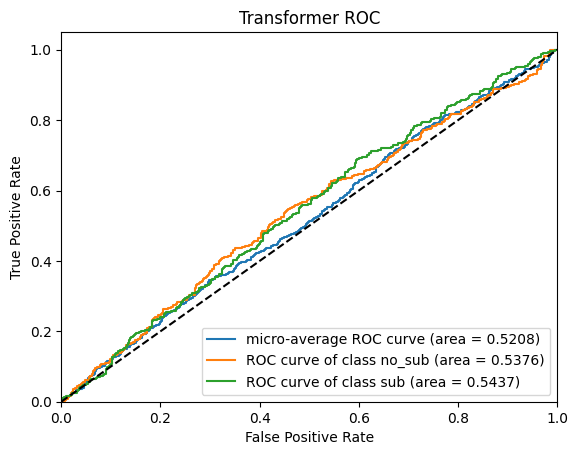

In [ ]:
num_classes = 2
def to_one_hot_vector(num_class, label):
    b = np.zeros((label.shape[0], num_class))
    b[np.arange(label.shape[0]), label] = 1

    return b.astype(int)

plt.rcParams.update(plt.rcParamsDefault)

total = 0
all_test_loss = []
all_test_accuracy = []
label_true_arr = []
label_true_arr_onehot = []
label_pred_arr = []
pred_arr = []

correct = 0
with torch.no_grad():
    model.eval()
    for i, (x, t) in enumerate(valid_loader):
        x = x.to(device)
        t = t.to(device)
        y = model(x)

        pred_arr.append(y.cpu().numpy())


        _, prediction = torch.max(y.data, 1)
        label_pred_arr.append(prediction.cpu().numpy())
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        label_true_arr.append(t.cpu().numpy())

        one_hot_t = to_one_hot_vector(num_classes,t.cpu().numpy())
        label_true_arr_onehot.append(one_hot_t)

y_pred = []
for i in label_pred_arr:
    for j in i:
        y_pred.append(j)
y_pred = np.array(y_pred)        
        
y_true_onehot = []
for i in label_true_arr_onehot:
    for j in i:
        y_true_onehot.append(list(j))
y_true_onehot = np.array(y_true_onehot)

y_score = []
for i in pred_arr:
    for j in i:
        y_score.append(list(j))
y_score = np.array(y_score)

y_true = []
for i in label_true_arr:
    for j in i:
        y_true.append(j)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


inv_map = {v: k for k, v in valset.class_to_idx.items()}



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ inv_map[i]+ ' (area = {0:0.4f})'
                                   ''.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC')
plt.legend(loc="lower right")
plt.show()